# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [51]:
#if you run on a server
!bash ../xvfb start
%env DISPLAY=:1

bash: ../xvfb: No such file or directory
env: DISPLAY=:1


In [105]:
import gym
import numpy as np, pandas as pd
import seaborn

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-02-26 18:28:56,388] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [64]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [65]:
policy = np.array([[1. / n_actions] * n_actions for _ in range(n_states)])

In [66]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [88]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(range(n_actions), size=1, p=policy[s])[0]
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [89]:
s,a,r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

# Training loop
Generate sessions, select N best and fit to those.

In [263]:
def training_loop(n_samples=250, percentile=25, smoothing=0.1, n_epoches=100):
    global policy
    thresholds, rewards = [], []
    for i in range(n_epoches):

        sessions = [generate_session() for _ in range(n_samples)]

        batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))

        #batch_states: a list of lists of states in each session
        #batch_actions: a list of lists of actions in each session
        #batch_rewards: a list of floats - total rewards at each session

        threshold = np.percentile(batch_rewards, percentile) 

        elite_states = batch_states[batch_rewards > threshold]
        elite_actions = batch_actions[batch_rewards > threshold]
        elite_rewards = batch_rewards[batch_rewards > threshold]

        elite_counts = np.zeros_like(policy) + smoothing

        for i in range(len(elite_states)):
            for j in range(len(elite_states[i])):
                r = elite_rewards[i]
                if r >= 0:
                    r = r ** 2
                else:
                    r = 1
                elite_counts[elite_states[i][j], elite_actions[i][j]] +=  r
        


        policy = elite_counts / elite_counts.sum(axis=1, keepdims=True)

        thresholds.append(threshold)
        rewards.append(np.mean(batch_rewards))
        if len(batch_rewards[batch_rewards >= 9]) > 0:
            print len(batch_rewards[batch_rewards >= 9]) * 1. / len(batch_rewards), ' - ok'
        print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
#         seaborn.distplot(batch_rewards)
#         seaborn.plt.show()

mean reward = -5703.13700	threshold = -15542.8


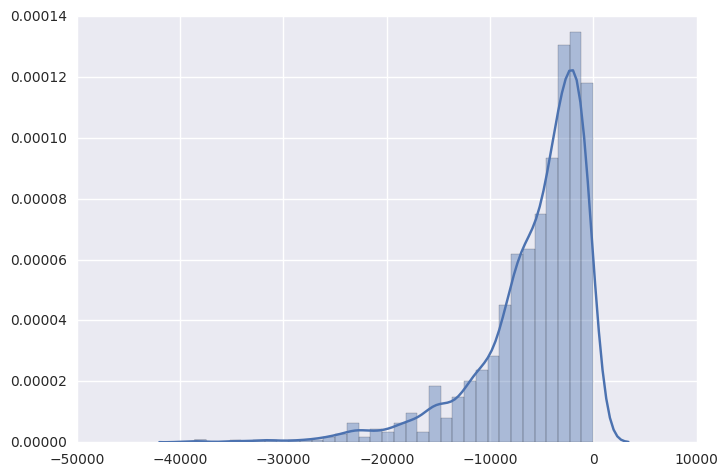

mean reward = -4635.36500	threshold = -13024.0


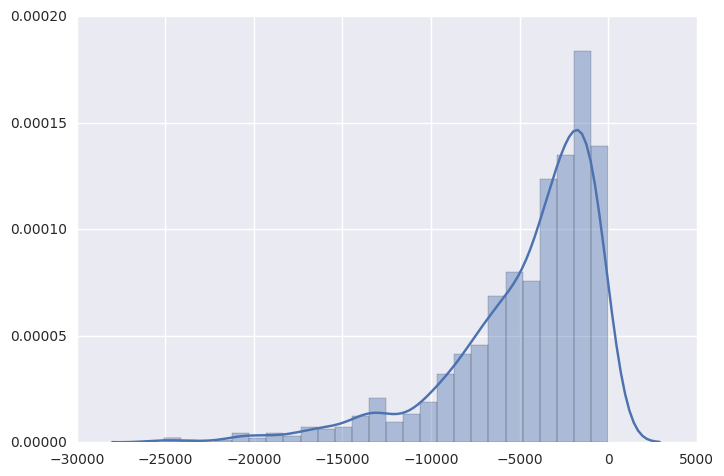

mean reward = -3822.70700	threshold = -10025.1


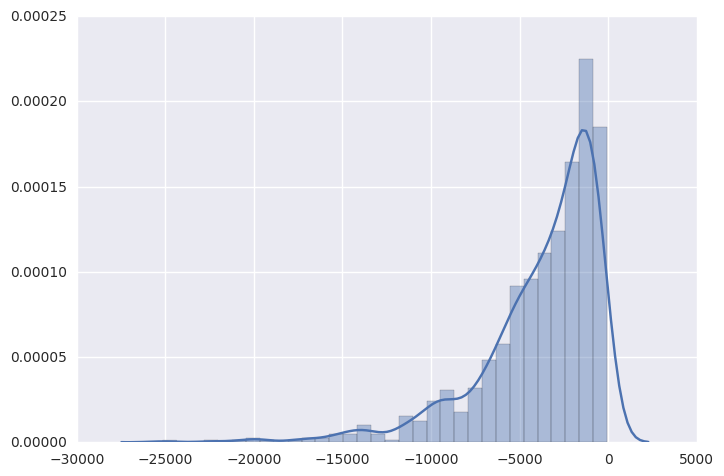

mean reward = -3079.16300	threshold = -8078.4


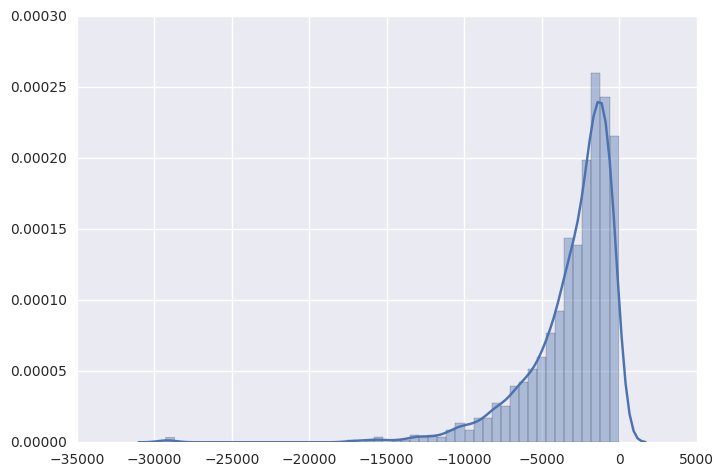

mean reward = -2512.87800	threshold = -6464.3


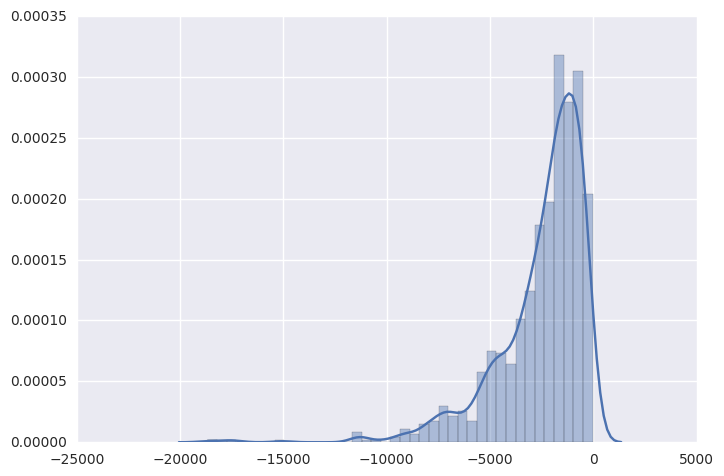

mean reward = -2066.32300	threshold = -4959.4


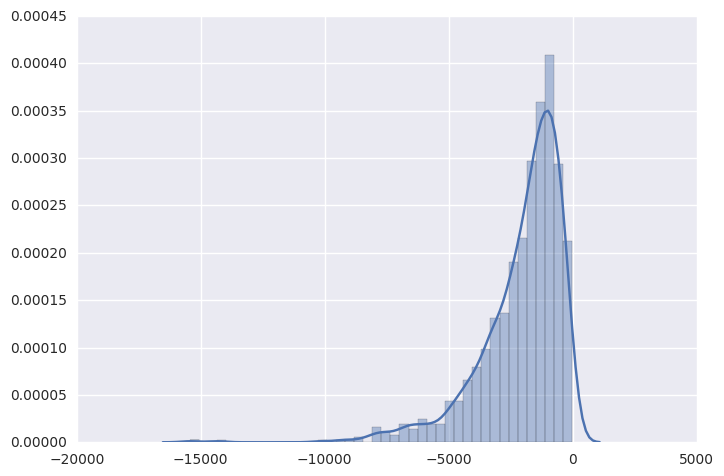

KeyboardInterrupt: 

In [228]:
# env.reset()
# policy = np.array([[1. / n_actions] * n_actions for _ in range(n_states)])
%time training_loop(n_samples=1000, percentile=6, n_epoches=10)

In [268]:
# env.reset()
# policy = np.array([[1. / n_actions] * n_actions for _ in range(n_states)])
%time training_loop(n_samples=900, percentile=1, smoothing=0.00001, n_epoches=20)

0.447777777778  - ok
mean reward = 7.95222	threshold = -5.0
0.441111111111  - ok
mean reward = 8.14333	threshold = 3.0
0.44  - ok
mean reward = 8.06222	threshold = -4.0
0.461111111111  - ok
mean reward = 8.14667	threshold = 2.9
0.431111111111  - ok
mean reward = 7.68444	threshold = -7.0
0.435555555556  - ok
mean reward = 7.51333	threshold = -8.0
0.442222222222  - ok
mean reward = 8.04556	threshold = 3.0
0.442222222222  - ok
mean reward = 7.92000	threshold = -3.0
0.442222222222  - ok
mean reward = 8.15667	threshold = 3.0
0.474444444444  - ok
mean reward = 8.25778	threshold = 3.0
0.423333333333  - ok
mean reward = 8.03778	threshold = 3.0
0.414444444444  - ok
mean reward = 8.05333	threshold = -3.0
0.448888888889  - ok
mean reward = 7.88556	threshold = -3.0
0.422222222222  - ok
mean reward = 8.14444	threshold = 3.0
0.426666666667  - ok
mean reward = 7.73111	threshold = -8.0
0.424444444444  - ok
mean reward = 7.93889	threshold = 2.0
0.474444444444  - ok
mean reward = 8.34222	threshold = 3.0

In [269]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap ?
env = env.env.env
#upload to gym


#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2017-02-26 22:09:50,601] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-26 22:09:50,603] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-02-26 22:09:50,605] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.28.12780.video000000.json
[2017-02-26 22:09:50,614] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.28.12780.video000001.json
[2017-02-26 22:09:50,627] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.28.12780.video000008.json
[2017-02-26 22:09:50,650] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.28

In [266]:
gym.upload("./videos/",api_key="sk_QqOIccK6Qxu4jbPHswDn8w") #you'll need me later

[2017-02-26 22:08:39,296] [Taxi-v1] Uploading 100 episodes of training data
[2017-02-26 22:08:40,667] [Taxi-v1] Uploading videos of 5 training episodes (1243 bytes)
[2017-02-26 22:08:41,119] [Taxi-v1] Creating evaluation object from ./videos/ with learning curve and training video
[2017-02-26 22:08:41,388] 
****************************************************
You successfully uploaded your evaluation on Taxi-v1 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_H5gSadavTxS9gF7EXbBHQ

****************************************************


# Approximate (deep) crossentropy method

In this section we will train a neural network policy for continuous action space game

[2017-02-26 16:17:21,695] Making new env: CartPole-v0


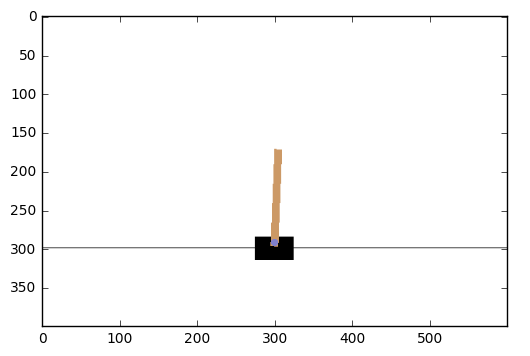

In [8]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [9]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


In [10]:
def generate_session(t_max=10000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(range(n_actions), size=1, p=probs)[0]
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [12]:
%%time

n_samples = 100
percentile = 70
smoothing = 0.01

for i in range(50):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session

    threshold = np.percentile(batch_rewards, percentile)
    
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #elite_states: a list of states from top games
    #elite_actions: a list of actions from top games
    
    agent.fit(elite_states, elite_actions)


    print("epoch = %d\tmean reward = %.5f\tthreshold = %.1f"%(i, np.mean(batch_rewards),threshold))

epoch = 0	mean reward = 501.58000	threshold = 605.2
epoch = 1	mean reward = 505.13000	threshold = 595.4
epoch = 2	mean reward = 599.59000	threshold = 730.6
epoch = 3	mean reward = 612.89000	threshold = 716.2
epoch = 4	mean reward = 603.79000	threshold = 723.0
epoch = 5	mean reward = 746.68000	threshold = 864.9
epoch = 6	mean reward = 756.48000	threshold = 870.8
epoch = 7	mean reward = 1067.42000	threshold = 1244.4
epoch = 8	mean reward = 1346.48000	threshold = 1524.3
epoch = 9	mean reward = 1514.65000	threshold = 1663.0
epoch = 10	mean reward = 1412.07000	threshold = 1720.4


KeyboardInterrupt: 

# Results

In [13]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
gym.upload("./videos/",api_key="sk_QqOIccK6Qxu4jbPHswDn8w") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2017-02-26 16:22:02,010] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-26 16:22:02,014] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-02-26 16:22:02,018] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.1.12780.video000000.mp4
[2017-02-26 16:22:05,443] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.1.12780.video000001.mp4
[2017-02-26 16:22:09,032] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.1.12780.video000008.mp4
[2017-02-26 16:22:12,996] Starting new video recorder writing to /home/spotapova/Yandex.Disk/work/shad/rl/week1/videos/openaigym.video.1.12780.

In [20]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular correntropy method

You may have noticed that the taxi problem quickly converges from -10k to aroung -500 score (+- 500) and stays there. This is in part because taxi-v2 has some hard-coded randomness in the environment. Other reason is that the percentile was chosen poorly.

### Tasks
- __1.1__ (1 pt) Modify the tabular CEM (CrossEntropyMethod) code to plot distribution of rewards and threshold on each tick.
- __1.2__ (2 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.

** Percentile: чем больше, тем отрицательнее (левее) располагаются на гистограмме худшие реворды. И наоборот, чем меньше, тем выше худшие из ревордов. **

** n_samples: с уменьшением теряется точность, но убыстряется процесс обучения. есть риск обучиться на плохих семплах, если очень маленький n_samples. **


- __1.3__ (2 pts) Tune the algorithm to end up with positive average score.
- __1.4 bonus__ (1 pt) Try to achieve a distribution where 25% or more samples score above +9.0
- __1.5 bonus__ (2 pts) Solve and upload [Taxi-v1](https://gym.openai.com/envs/Taxi-v1) to the openai gym.

It's okay to modify the existing code.


# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ Go to the [gym site](http://gym.openai.com/), register and obtain __api key__.
* __2.2__ (1 pt) Upload your result to gym via gym.upload (see Results tab above, the line you need is commented)
* __2.3__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2 (or both) and solve it (see tips below)
  * For MountainCar, learn to finish it in __less than 180 steps__
  * For LunarLander, learn to get reward of __at least +50__
* __2.4__ (1+ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Bonus tasks

* __2.5 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation_)

* __2.6 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (4+ points if it works)
  
* __2.7 bonus__ Use any deep learning framework of your choice to implement policy-gradient (see lectures) on any of those envs (4 +1 per env):
  * CartPole-v0
  * MountainCar-v0
  * LunarLander-v2
  * See __tips on policy gradient__ below.
  

* __2.8 bonus__ take your favorite deep learning framework and try to get above random in [Atari Breakout](https://gym.openai.com/envs/Breakout-v0) with crossentropy method over a convolutional network.
  * Expect at least +10 points if you get this up and running, no deadlines apply ! 
  * __See tips below on where to start, they're cruicially important__

[2017-02-26 22:26:42,078] Making new env: LunarLander-v2


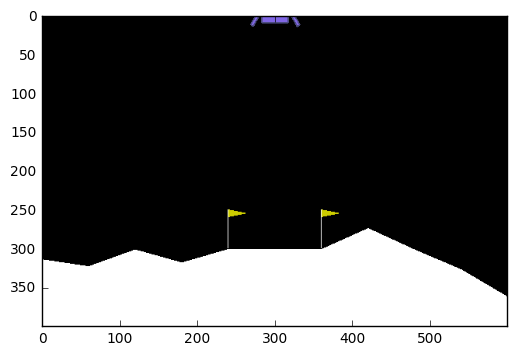

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("LunarLander-v2")
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [3]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(128,64,128),
#                       activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [10]:
def generate_session(t_max=10000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(range(n_actions), size=1, p=probs)[0]
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [6]:
def training_loop(n_samples=100, percentile=70, smoothing=0.01, n_epoches=50):

    for i in range(n_epoches):
        #generate new sessions
        sessions = [generate_session() for _ in range(n_samples)]

        batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
        #batch_states: a list of lists of states in each session
        #batch_actions: a list of lists of actions in each session
        #batch_rewards: a list of floats - total rewards at each session

        threshold = np.percentile(batch_rewards, percentile)

        elite_states = batch_states[batch_rewards > threshold]
        elite_actions = batch_actions[batch_rewards > threshold]

        elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
        #elite_states: a list of states from top games
        #elite_actions: a list of actions from top games

        agent.fit(elite_states, elite_actions)


        print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

In [19]:
training_loop(n_samples=100, percentile=10, n_epoches=100)

mean reward = 39.27327    threshold = 11.4
mean reward = 41.03188    threshold = 11.3
mean reward = 43.79939    threshold = 13.8
mean reward = 39.82018    threshold = 9.7
mean reward = 34.68736    threshold = 3.3
mean reward = 31.67267    threshold = 1.7
mean reward = 28.57021    threshold = 5.8
mean reward = 25.37441    threshold = 2.5
mean reward = 24.40826    threshold = 3.0
mean reward = 30.74622    threshold = 9.0
mean reward = 34.88640    threshold = 13.7
mean reward = 36.84687    threshold = 8.7
mean reward = 39.23501    threshold = 9.6
mean reward = 43.25444    threshold = 14.6
mean reward = 44.25133    threshold = 14.4
mean reward = 46.79662    threshold = 17.0
mean reward = 47.49645    threshold = 20.4
mean reward = 49.03672    threshold = 21.4
mean reward = 50.59652    threshold = 23.4
mean reward = 49.52084    threshold = 20.7


### Tips on policy gradient

* The loss function is very similar to crossentropy method. You can get away with using rewards as  __sample_weights__.
* If your algorithm converges to a poor strategy, try regularizing with entropy or just somehow prevent agent from picking actions deterministically (e.g. when probs = 0,0,1,0,0)
* We will use `lasagne` later in the course so you can try to [learn it](http://lasagne.readthedocs.io/en/latest/user/tutorial.html).
* If you don't want to mess with theano just yet, try [keras](https://keras.io/getting-started/sequential-model-guide/) or [mxnet](http://mxnet.io/tutorials/index.html).


 ### Tips on atari breakout

* There's all the pre-processing and tuning done for you in the code below
* Once you got it working, it's probably a good idea to pre-train with autoencoder or something
* We use last 4 frames as observations to account for ball velocity
* The code below requires ```pip install Image``` and ```pip install gym[atari]```

In [2]:
from breakout import make_breakout

env = make_breakout()
env.action_space

[2017-02-15 20:01:46,560] Making new env: BreakoutDeterministic-v0


Discrete(6)

In [3]:
#get the initial state
s = env.reset()
print (s.shape)

(4, 64, 64)


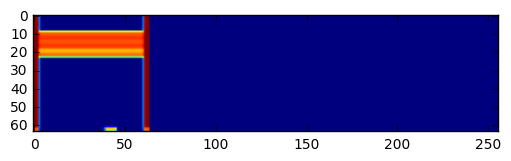

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot first observation. Only one frame
plt.imshow(s.swapaxes(1,2).reshape(-1,64).T)

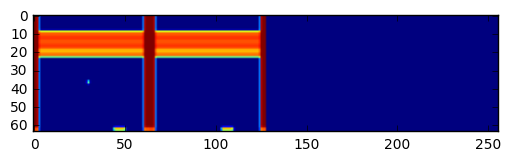

In [5]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

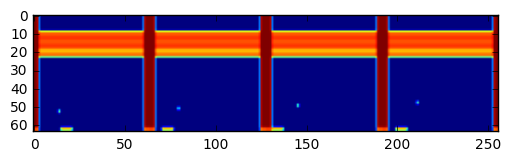

In [6]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
< tons of your code here or elsewhere >